In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = "MNIST"
model_name = "flow_vcr_mse"
ood = "0"

In [3]:
# Parameters
ood = 2


In [4]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

  0%|                                                                                                        | 0/60000 [00:00<?, ?it/s]

 11%|█████████▌                                                                                | 6376/60000 [00:00<00:00, 63749.73it/s]

 22%|███████████████████▋                                                                     | 13234/60000 [00:00<00:00, 66587.36it/s]

 34%|█████████████████████████████▉                                                           | 20144/60000 [00:00<00:00, 67731.03it/s]

 45%|████████████████████████████████████████▏                                                | 27092/60000 [00:00<00:00, 68418.32it/s]

 57%|██████████████████████████████████████████████████▌                                      | 34069/60000 [00:00<00:00, 68905.20it/s]

 68%|████████████████████████████████████████████████████████████▊                            | 40960/60000 [00:00<00:00, 68876.76it/s]

 80%|██████████████████████████████████████████████████████████████████████▉                  | 47858/60000 [00:00<00:00, 68907.25it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▏       | 54749/60000 [00:00<00:00, 68870.52it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████| 60000/60000 [00:00<00:00, 68355.91it/s]

  0%|                                                                                                        | 0/10000 [00:00<?, ?it/s]

 69%|██████████████████████████████████████████████████████████████▏                           | 6908/10000 [00:00<00:00, 69077.27it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 68058.08it/s]

In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

In [6]:
# model ids
model_ids = {
    "0:1:2:3:4": '59ftut3f',
    "5:6:7:8:9": "lz2g3fq1",
    "0": "cpnxtpv2",
    "1": "c6sohudf",
    "2": "5qeniujh",
    "3": "cto6ipr0",
}
ood_str = ":".join(map(str, config.ood))
model_id = model_ids[ood_str]
print(ood_str, model_id)

2 5qeniujh


In [7]:
model = config.get_model()

In [8]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robust_ml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [10]:
from models.common import edl_probs
from tqdm import tqdm

trn_targets = []
val_targets = []
ind_targets = []
if ood_str:
    ood_targets = []

trn_u_norms = []
val_u_norms = []
ind_u_norms = []
if ood_str:
    ood_u_norms = []
rnd_u_norms = []

trn_v_norms = []
val_v_norms = []
ind_v_norms = []
if ood_str:
    ood_v_norms = []
rnd_v_norms = []

# train set (ind)
for batch_idx, batch in enumerate(tqdm(train_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    trn_u_norms.extend(u_norm.detach().cpu().numpy())
    trn_v_norms.extend(v_norm.detach().cpu().numpy())
    trn_targets.extend(y.detach().cpu().numpy())
print("train - OK")

# val set (ind)
for batch_idx, batch in enumerate(tqdm(val_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    val_u_norms.extend(u_norm.detach().cpu().numpy())
    val_v_norms.extend(v_norm.detach().cpu().numpy())
    val_targets.extend(y.detach().cpu().numpy())
print("val - OK")

# test set (ind)
for batch_idx, batch in enumerate(tqdm(test_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    ind_u_norms.extend(u_norm.detach().cpu().numpy())
    ind_v_norms.extend(v_norm.detach().cpu().numpy())
    ind_targets.extend(y.detach().cpu().numpy())
print("test InD - OK")

# predict set (ood)
if ood_str:
    for batch_idx, batch in enumerate(tqdm(predict_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        v, z, x_m, u_norm, v_norm, logits = model(x)
        ood_u_norms.extend(u_norm.detach().cpu().numpy())
        ood_v_norms.extend(v_norm.detach().cpu().numpy())
        ood_targets.extend(y.detach().cpu().numpy())
    print("test OoD - OK")

# random set
rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
for batch_idx, batch in enumerate(tqdm(rnd_set)):
    x = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    rnd_u_norms.extend(u_norm.detach().cpu().numpy())
    rnd_v_norms.extend(v_norm.detach().cpu().numpy())
print("test RnD - OK")

trn_targets = np.array(trn_targets).squeeze()
val_targets = np.array(val_targets).squeeze()
ind_targets = np.array(ind_targets).squeeze()
if ood_str:
    ood_targets = np.array(ood_targets).squeeze()

trn_u_norms = np.array(trn_u_norms).squeeze()
val_u_norms = np.array(val_u_norms).squeeze()
ind_u_norms = np.array(ind_u_norms).squeeze()
if ood_str:
    ood_u_norms = np.array(ood_u_norms).squeeze()
rnd_u_norms = np.array(rnd_u_norms).squeeze()

trn_v_norms = np.array(trn_v_norms).squeeze()
val_v_norms = np.array(val_v_norms).squeeze()
ind_v_norms = np.array(ind_v_norms).squeeze()
if ood_str:
    ood_v_norms = np.array(ood_v_norms).squeeze()
rnd_v_norms = np.array(rnd_v_norms).squeeze()

print(trn_u_norms.shape, trn_v_norms.shape)
print(val_u_norms.shape, val_v_norms.shape)
print(ind_u_norms.shape, ind_v_norms.shape)
if ood_str:
    print(ood_u_norms.shape, ood_v_norms.shape)
print(rnd_u_norms.shape, rnd_v_norms.shape)

  0%|                                                                                                          | 0/676 [00:00<?, ?it/s]

  0%|▏                                                                                                 | 1/676 [00:00<10:02,  1.12it/s]

  1%|▌                                                                                                 | 4/676 [00:00<02:11,  5.09it/s]

  1%|█▏                                                                                                | 8/676 [00:01<01:03, 10.49it/s]

  2%|█▋                                                                                               | 12/676 [00:01<00:43, 15.43it/s]

  2%|██▎                                                                                              | 16/676 [00:01<00:33, 19.77it/s]

  3%|██▊                                                                                              | 20/676 [00:01<00:27, 23.44it/s]

  4%|███▍                                                                                             | 24/676 [00:01<00:24, 26.40it/s]

  4%|████                                                                                             | 28/676 [00:01<00:22, 28.69it/s]

  5%|████▌                                                                                            | 32/676 [00:01<00:21, 30.48it/s]

  5%|█████▏                                                                                           | 36/676 [00:01<00:20, 31.73it/s]

  6%|█████▋                                                                                           | 40/676 [00:02<00:19, 32.65it/s]

  7%|██████▎                                                                                          | 44/676 [00:02<00:18, 33.34it/s]

  7%|██████▉                                                                                          | 48/676 [00:02<00:18, 33.75it/s]

  8%|███████▍                                                                                         | 52/676 [00:02<00:18, 34.08it/s]

  8%|████████                                                                                         | 56/676 [00:02<00:18, 34.34it/s]

  9%|████████▌                                                                                        | 60/676 [00:02<00:17, 34.48it/s]

  9%|█████████▏                                                                                       | 64/676 [00:02<00:17, 34.61it/s]

 10%|█████████▊                                                                                       | 68/676 [00:02<00:17, 34.76it/s]

 11%|██████████▎                                                                                      | 72/676 [00:02<00:17, 34.79it/s]

 11%|██████████▉                                                                                      | 76/676 [00:03<00:17, 34.89it/s]

 12%|███████████▍                                                                                     | 80/676 [00:03<00:17, 34.92it/s]

 12%|████████████                                                                                     | 84/676 [00:03<00:16, 34.90it/s]

 13%|████████████▋                                                                                    | 88/676 [00:03<00:16, 34.79it/s]

 14%|█████████████▏                                                                                   | 92/676 [00:03<00:16, 34.80it/s]

 14%|█████████████▊                                                                                   | 96/676 [00:03<00:16, 34.88it/s]

 15%|██████████████▏                                                                                 | 100/676 [00:03<00:16, 34.93it/s]

 15%|██████████████▊                                                                                 | 104/676 [00:03<00:16, 34.64it/s]

 16%|███████████████▎                                                                                | 108/676 [00:03<00:16, 34.82it/s]

 17%|███████████████▉                                                                                | 112/676 [00:04<00:16, 34.80it/s]

 17%|████████████████▍                                                                               | 116/676 [00:04<00:16, 34.88it/s]

 18%|█████████████████                                                                               | 120/676 [00:04<00:15, 34.79it/s]

 18%|█████████████████▌                                                                              | 124/676 [00:04<00:15, 34.78it/s]

 19%|██████████████████▏                                                                             | 128/676 [00:04<00:15, 34.82it/s]

 20%|██████████████████▋                                                                             | 132/676 [00:04<00:15, 34.87it/s]

 20%|███████████████████▎                                                                            | 136/676 [00:04<00:15, 34.83it/s]

 21%|███████████████████▉                                                                            | 140/676 [00:04<00:15, 34.87it/s]

 21%|████████████████████▍                                                                           | 144/676 [00:05<00:15, 34.79it/s]

 22%|█████████████████████                                                                           | 148/676 [00:05<00:15, 34.85it/s]

 22%|█████████████████████▌                                                                          | 152/676 [00:05<00:15, 34.86it/s]

 23%|██████████████████████▏                                                                         | 156/676 [00:05<00:14, 34.82it/s]

 24%|██████████████████████▋                                                                         | 160/676 [00:05<00:14, 34.81it/s]

 24%|███████████████████████▎                                                                        | 164/676 [00:05<00:14, 34.76it/s]

 25%|███████████████████████▊                                                                        | 168/676 [00:05<00:14, 34.76it/s]

 25%|████████████████████████▍                                                                       | 172/676 [00:05<00:14, 34.83it/s]

 26%|████████████████████████▉                                                                       | 176/676 [00:05<00:14, 34.82it/s]

 27%|█████████████████████████▌                                                                      | 180/676 [00:06<00:14, 34.85it/s]

 27%|██████████████████████████▏                                                                     | 184/676 [00:06<00:14, 34.87it/s]

 28%|██████████████████████████▋                                                                     | 188/676 [00:06<00:14, 34.83it/s]

 28%|███████████████████████████▎                                                                    | 192/676 [00:06<00:13, 34.77it/s]

 29%|███████████████████████████▊                                                                    | 196/676 [00:06<00:13, 34.78it/s]

 30%|████████████████████████████▍                                                                   | 200/676 [00:06<00:13, 34.80it/s]

 30%|████████████████████████████▉                                                                   | 204/676 [00:06<00:13, 34.74it/s]

 31%|█████████████████████████████▌                                                                  | 208/676 [00:06<00:13, 34.78it/s]

 31%|██████████████████████████████                                                                  | 212/676 [00:06<00:13, 34.82it/s]

 32%|██████████████████████████████▋                                                                 | 216/676 [00:07<00:13, 34.85it/s]

 33%|███████████████████████████████▏                                                                | 220/676 [00:07<00:13, 34.86it/s]

 33%|███████████████████████████████▊                                                                | 224/676 [00:07<00:12, 34.87it/s]

 34%|████████████████████████████████▍                                                               | 228/676 [00:07<00:12, 34.81it/s]

 34%|████████████████████████████████▉                                                               | 232/676 [00:07<00:12, 34.88it/s]

 35%|█████████████████████████████████▌                                                              | 236/676 [00:07<00:12, 34.90it/s]

 36%|██████████████████████████████████                                                              | 240/676 [00:07<00:12, 34.86it/s]

 36%|██████████████████████████████████▋                                                             | 244/676 [00:07<00:12, 34.86it/s]

 37%|███████████████████████████████████▏                                                            | 248/676 [00:08<00:12, 34.81it/s]

 37%|███████████████████████████████████▊                                                            | 252/676 [00:08<00:12, 34.82it/s]

 38%|████████████████████████████████████▎                                                           | 256/676 [00:08<00:12, 34.85it/s]

 38%|████████████████████████████████████▉                                                           | 260/676 [00:08<00:11, 34.82it/s]

 39%|█████████████████████████████████████▍                                                          | 264/676 [00:08<00:11, 34.88it/s]

 40%|██████████████████████████████████████                                                          | 268/676 [00:08<00:11, 34.80it/s]

 40%|██████████████████████████████████████▋                                                         | 272/676 [00:08<00:11, 34.85it/s]

 41%|███████████████████████████████████████▏                                                        | 276/676 [00:08<00:11, 34.86it/s]

 41%|███████████████████████████████████████▊                                                        | 280/676 [00:08<00:11, 34.80it/s]

 42%|████████████████████████████████████████▎                                                       | 284/676 [00:09<00:11, 34.81it/s]

 43%|████████████████████████████████████████▉                                                       | 288/676 [00:09<00:11, 34.85it/s]

 43%|█████████████████████████████████████████▍                                                      | 292/676 [00:09<00:11, 34.80it/s]

 44%|██████████████████████████████████████████                                                      | 296/676 [00:09<00:10, 34.80it/s]

 44%|██████████████████████████████████████████▌                                                     | 300/676 [00:09<00:10, 34.79it/s]

 45%|███████████████████████████████████████████▏                                                    | 304/676 [00:09<00:10, 34.83it/s]

 46%|███████████████████████████████████████████▋                                                    | 308/676 [00:09<00:10, 34.80it/s]

 46%|████████████████████████████████████████████▎                                                   | 312/676 [00:09<00:10, 34.52it/s]

 47%|████████████████████████████████████████████▉                                                   | 316/676 [00:09<00:10, 34.68it/s]

 47%|█████████████████████████████████████████████▍                                                  | 320/676 [00:10<00:10, 34.73it/s]

 48%|██████████████████████████████████████████████                                                  | 324/676 [00:10<00:10, 34.80it/s]

 49%|██████████████████████████████████████████████▌                                                 | 328/676 [00:10<00:10, 34.78it/s]

 49%|███████████████████████████████████████████████▏                                                | 332/676 [00:10<00:09, 34.80it/s]

 50%|███████████████████████████████████████████████▋                                                | 336/676 [00:10<00:09, 34.81it/s]

 50%|████████████████████████████████████████████████▎                                               | 340/676 [00:10<00:09, 34.77it/s]

 51%|████████████████████████████████████████████████▊                                               | 344/676 [00:10<00:09, 34.78it/s]

 51%|█████████████████████████████████████████████████▍                                              | 348/676 [00:10<00:09, 34.74it/s]

 52%|█████████████████████████████████████████████████▉                                              | 352/676 [00:10<00:09, 34.81it/s]

 53%|██████████████████████████████████████████████████▌                                             | 356/676 [00:11<00:09, 34.88it/s]

 53%|███████████████████████████████████████████████████                                             | 360/676 [00:11<00:09, 34.86it/s]

 54%|███████████████████████████████████████████████████▋                                            | 364/676 [00:11<00:08, 34.85it/s]

 54%|████████████████████████████████████████████████████▎                                           | 368/676 [00:11<00:08, 34.86it/s]

 55%|████████████████████████████████████████████████████▊                                           | 372/676 [00:11<00:08, 34.86it/s]

 56%|█████████████████████████████████████████████████████▍                                          | 376/676 [00:11<00:08, 34.87it/s]

 56%|█████████████████████████████████████████████████████▉                                          | 380/676 [00:11<00:08, 34.82it/s]

 57%|██████████████████████████████████████████████████████▌                                         | 384/676 [00:11<00:08, 34.82it/s]

 57%|███████████████████████████████████████████████████████                                         | 388/676 [00:12<00:08, 34.86it/s]

 58%|███████████████████████████████████████████████████████▋                                        | 392/676 [00:12<00:08, 34.88it/s]

 59%|████████████████████████████████████████████████████████▏                                       | 396/676 [00:12<00:08, 34.86it/s]

 59%|████████████████████████████████████████████████████████▊                                       | 400/676 [00:12<00:07, 34.87it/s]

 60%|█████████████████████████████████████████████████████████▎                                      | 404/676 [00:12<00:07, 34.80it/s]

 60%|█████████████████████████████████████████████████████████▉                                      | 408/676 [00:12<00:07, 34.81it/s]

 61%|██████████████████████████████████████████████████████████▌                                     | 412/676 [00:12<00:07, 34.84it/s]

 62%|███████████████████████████████████████████████████████████                                     | 416/676 [00:12<00:07, 34.68it/s]

 62%|███████████████████████████████████████████████████████████▋                                    | 420/676 [00:12<00:07, 34.68it/s]

 63%|████████████████████████████████████████████████████████████▏                                   | 424/676 [00:13<00:07, 34.78it/s]

 63%|████████████████████████████████████████████████████████████▊                                   | 428/676 [00:13<00:07, 34.83it/s]

 64%|█████████████████████████████████████████████████████████████▎                                  | 432/676 [00:13<00:07, 34.85it/s]

 64%|█████████████████████████████████████████████████████████████▉                                  | 436/676 [00:13<00:06, 34.64it/s]

 65%|██████████████████████████████████████████████████████████████▍                                 | 440/676 [00:13<00:06, 34.61it/s]

 66%|███████████████████████████████████████████████████████████████                                 | 444/676 [00:13<00:06, 34.66it/s]

 66%|███████████████████████████████████████████████████████████████▌                                | 448/676 [00:13<00:06, 34.69it/s]

 67%|████████████████████████████████████████████████████████████████▏                               | 452/676 [00:13<00:06, 34.71it/s]

 67%|████████████████████████████████████████████████████████████████▊                               | 456/676 [00:13<00:06, 34.67it/s]

 68%|█████████████████████████████████████████████████████████████████▎                              | 460/676 [00:14<00:06, 34.70it/s]

 69%|█████████████████████████████████████████████████████████████████▉                              | 464/676 [00:14<00:06, 34.60it/s]

 69%|██████████████████████████████████████████████████████████████████▍                             | 468/676 [00:14<00:06, 34.65it/s]

 70%|███████████████████████████████████████████████████████████████████                             | 472/676 [00:14<00:05, 34.66it/s]

 70%|███████████████████████████████████████████████████████████████████▌                            | 476/676 [00:14<00:05, 34.68it/s]

 71%|████████████████████████████████████████████████████████████████████▏                           | 480/676 [00:14<00:05, 34.73it/s]

 72%|████████████████████████████████████████████████████████████████████▋                           | 484/676 [00:14<00:05, 34.72it/s]

 72%|█████████████████████████████████████████████████████████████████████▎                          | 488/676 [00:14<00:05, 34.75it/s]

 73%|█████████████████████████████████████████████████████████████████████▊                          | 492/676 [00:15<00:05, 34.77it/s]

 73%|██████████████████████████████████████████████████████████████████████▍                         | 496/676 [00:15<00:05, 34.78it/s]

 74%|███████████████████████████████████████████████████████████████████████                         | 500/676 [00:15<00:05, 34.68it/s]

 75%|███████████████████████████████████████████████████████████████████████▌                        | 504/676 [00:15<00:04, 34.54it/s]

 75%|████████████████████████████████████████████████████████████████████████▏                       | 508/676 [00:15<00:04, 34.44it/s]

 76%|████████████████████████████████████████████████████████████████████████▋                       | 512/676 [00:15<00:04, 34.36it/s]

 76%|█████████████████████████████████████████████████████████████████████████▎                      | 516/676 [00:15<00:04, 34.51it/s]

 77%|█████████████████████████████████████████████████████████████████████████▊                      | 520/676 [00:15<00:04, 34.45it/s]

 78%|██████████████████████████████████████████████████████████████████████████▍                     | 524/676 [00:15<00:04, 34.44it/s]

 78%|██████████████████████████████████████████████████████████████████████████▉                     | 528/676 [00:16<00:04, 34.56it/s]

 79%|███████████████████████████████████████████████████████████████████████████▌                    | 532/676 [00:16<00:04, 34.67it/s]

 79%|████████████████████████████████████████████████████████████████████████████                    | 536/676 [00:16<00:04, 34.67it/s]

 80%|████████████████████████████████████████████████████████████████████████████▋                   | 540/676 [00:16<00:03, 34.71it/s]

 80%|█████████████████████████████████████████████████████████████████████████████▎                  | 544/676 [00:16<00:03, 34.73it/s]

 81%|█████████████████████████████████████████████████████████████████████████████▊                  | 548/676 [00:16<00:03, 34.79it/s]

 82%|██████████████████████████████████████████████████████████████████████████████▍                 | 552/676 [00:16<00:03, 34.81it/s]

 82%|██████████████████████████████████████████████████████████████████████████████▉                 | 556/676 [00:16<00:03, 34.84it/s]

 83%|███████████████████████████████████████████████████████████████████████████████▌                | 560/676 [00:16<00:03, 34.85it/s]

 83%|████████████████████████████████████████████████████████████████████████████████                | 564/676 [00:17<00:03, 34.72it/s]

 84%|████████████████████████████████████████████████████████████████████████████████▋               | 568/676 [00:17<00:03, 34.58it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████▏              | 572/676 [00:17<00:03, 34.60it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████▊              | 576/676 [00:17<00:02, 33.66it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████▎             | 580/676 [00:17<00:02, 33.93it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████▉             | 584/676 [00:17<00:02, 33.96it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████▌            | 588/676 [00:17<00:02, 34.15it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████            | 592/676 [00:17<00:02, 34.24it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████▋           | 596/676 [00:18<00:02, 34.31it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████▏          | 600/676 [00:18<00:02, 34.33it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████▊          | 604/676 [00:18<00:02, 34.38it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████▎         | 608/676 [00:18<00:01, 34.22it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████▉         | 612/676 [00:18<00:01, 34.16it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████▍        | 616/676 [00:18<00:01, 34.14it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████        | 620/676 [00:18<00:01, 34.23it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████▌       | 624/676 [00:18<00:01, 34.29it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████▏      | 628/676 [00:18<00:01, 34.31it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████▊      | 632/676 [00:19<00:01, 34.38it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████▎     | 636/676 [00:19<00:01, 34.35it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████▉     | 640/676 [00:19<00:01, 34.36it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████▍    | 644/676 [00:19<00:00, 34.19it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████    | 648/676 [00:19<00:00, 34.26it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████▌   | 652/676 [00:19<00:00, 34.31it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████▏  | 656/676 [00:19<00:00, 34.35it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████▋  | 660/676 [00:19<00:00, 34.42it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████▎ | 664/676 [00:20<00:00, 34.40it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████▊ | 668/676 [00:20<00:00, 34.34it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████▍| 672/676 [00:20<00:00, 34.94it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 676/676 [00:20<00:00, 30.78it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 676/676 [00:20<00:00, 33.06it/s]

train - OK


  0%|                                                                                                          | 0/169 [00:00<?, ?it/s]

  1%|▌                                                                                                 | 1/169 [00:00<00:24,  6.91it/s]

  3%|██▉                                                                                               | 5/169 [00:00<00:07, 21.17it/s]

  5%|█████▏                                                                                            | 9/169 [00:00<00:06, 26.59it/s]

  8%|███████▍                                                                                         | 13/169 [00:00<00:05, 29.37it/s]

 10%|█████████▊                                                                                       | 17/169 [00:00<00:04, 30.92it/s]

 12%|████████████                                                                                     | 21/169 [00:00<00:04, 31.79it/s]

 15%|██████████████▎                                                                                  | 25/169 [00:00<00:04, 32.41it/s]

 17%|████████████████▋                                                                                | 29/169 [00:00<00:04, 32.83it/s]

 20%|██████████████████▉                                                                              | 33/169 [00:01<00:04, 33.15it/s]

 22%|█████████████████████▏                                                                           | 37/169 [00:01<00:03, 33.38it/s]

 24%|███████████████████████▌                                                                         | 41/169 [00:01<00:03, 33.53it/s]

 27%|█████████████████████████▊                                                                       | 45/169 [00:01<00:03, 33.59it/s]

 29%|████████████████████████████                                                                     | 49/169 [00:01<00:03, 33.59it/s]

 31%|██████████████████████████████▍                                                                  | 53/169 [00:01<00:03, 33.68it/s]

 34%|████████████████████████████████▋                                                                | 57/169 [00:01<00:03, 33.70it/s]

 36%|███████████████████████████████████                                                              | 61/169 [00:01<00:03, 33.70it/s]

 38%|█████████████████████████████████████▎                                                           | 65/169 [00:02<00:03, 33.73it/s]

 41%|███████████████████████████████████████▌                                                         | 69/169 [00:02<00:02, 33.73it/s]

 43%|█████████████████████████████████████████▉                                                       | 73/169 [00:02<00:02, 33.69it/s]

 46%|████████████████████████████████████████████▏                                                    | 77/169 [00:02<00:02, 33.68it/s]

 48%|██████████████████████████████████████████████▍                                                  | 81/169 [00:02<00:02, 33.70it/s]

 50%|████████████████████████████████████████████████▊                                                | 85/169 [00:02<00:02, 33.65it/s]

 53%|███████████████████████████████████████████████████                                              | 89/169 [00:02<00:02, 33.64it/s]

 55%|█████████████████████████████████████████████████████▍                                           | 93/169 [00:02<00:02, 33.68it/s]

 57%|███████████████████████████████████████████████████████▋                                         | 97/169 [00:02<00:02, 33.68it/s]

 60%|█████████████████████████████████████████████████████████▎                                      | 101/169 [00:03<00:02, 33.71it/s]

 62%|███████████████████████████████████████████████████████████▋                                    | 105/169 [00:03<00:01, 33.74it/s]

 64%|█████████████████████████████████████████████████████████████▉                                  | 109/169 [00:03<00:01, 33.75it/s]

 67%|████████████████████████████████████████████████████████████████▏                               | 113/169 [00:03<00:01, 33.78it/s]

 69%|██████████████████████████████████████████████████████████████████▍                             | 117/169 [00:03<00:01, 33.76it/s]

 72%|████████████████████████████████████████████████████████████████████▋                           | 121/169 [00:03<00:01, 33.75it/s]

 74%|███████████████████████████████████████████████████████████████████████                         | 125/169 [00:03<00:01, 33.75it/s]

 76%|█████████████████████████████████████████████████████████████████████████▎                      | 129/169 [00:03<00:01, 33.75it/s]

 79%|███████████████████████████████████████████████████████████████████████████▌                    | 133/169 [00:04<00:01, 33.73it/s]

 81%|█████████████████████████████████████████████████████████████████████████████▊                  | 137/169 [00:04<00:00, 33.76it/s]

 83%|████████████████████████████████████████████████████████████████████████████████                | 141/169 [00:04<00:00, 33.78it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████▎             | 145/169 [00:04<00:00, 33.85it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████▋           | 149/169 [00:04<00:00, 33.84it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████▉         | 153/169 [00:04<00:00, 33.87it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████▏      | 157/169 [00:04<00:00, 33.83it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████▍    | 161/169 [00:04<00:00, 33.82it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████▋  | 165/169 [00:04<00:00, 34.59it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 169/169 [00:05<00:00, 33.18it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 169/169 [00:05<00:00, 32.73it/s]

val - OK


  0%|                                                                                                          | 0/141 [00:00<?, ?it/s]

  1%|▋                                                                                                 | 1/141 [00:00<00:20,  6.97it/s]

  4%|███▍                                                                                              | 5/141 [00:00<00:06, 21.26it/s]

  6%|██████▎                                                                                           | 9/141 [00:00<00:04, 26.86it/s]

  9%|████████▉                                                                                        | 13/141 [00:00<00:04, 29.62it/s]

 12%|███████████▋                                                                                     | 17/141 [00:00<00:03, 31.18it/s]

 15%|██████████████▍                                                                                  | 21/141 [00:00<00:03, 32.12it/s]

 18%|█████████████████▏                                                                               | 25/141 [00:00<00:03, 32.67it/s]

 21%|███████████████████▉                                                                             | 29/141 [00:00<00:03, 33.09it/s]

 23%|██████████████████████▋                                                                          | 33/141 [00:01<00:03, 33.37it/s]

 26%|█████████████████████████▍                                                                       | 37/141 [00:01<00:03, 33.61it/s]

 29%|████████████████████████████▏                                                                    | 41/141 [00:01<00:03, 33.17it/s]

 32%|██████████████████████████████▉                                                                  | 45/141 [00:01<00:02, 33.42it/s]

 35%|█████████████████████████████████▋                                                               | 49/141 [00:01<00:02, 33.74it/s]

 38%|████████████████████████████████████▍                                                            | 53/141 [00:01<00:02, 34.01it/s]

 40%|███████████████████████████████████████▏                                                         | 57/141 [00:01<00:02, 34.07it/s]

 43%|█████████████████████████████████████████▉                                                       | 61/141 [00:01<00:02, 34.11it/s]

 46%|████████████████████████████████████████████▋                                                    | 65/141 [00:02<00:02, 34.23it/s]

 49%|███████████████████████████████████████████████▍                                                 | 69/141 [00:02<00:02, 34.27it/s]

 52%|██████████████████████████████████████████████████▏                                              | 73/141 [00:02<00:01, 34.36it/s]

 55%|████████████████████████████████████████████████████▉                                            | 77/141 [00:02<00:01, 34.42it/s]

 57%|███████████████████████████████████████████████████████▋                                         | 81/141 [00:02<00:01, 34.48it/s]

 60%|██████████████████████████████████████████████████████████▍                                      | 85/141 [00:02<00:01, 34.52it/s]

 63%|█████████████████████████████████████████████████████████████▏                                   | 89/141 [00:02<00:01, 34.54it/s]

 66%|███████████████████████████████████████████████████████████████▉                                 | 93/141 [00:02<00:01, 34.51it/s]

 69%|██████████████████████████████████████████████████████████████████▋                              | 97/141 [00:02<00:01, 34.51it/s]

 72%|████████████████████████████████████████████████████████████████████▊                           | 101/141 [00:03<00:01, 34.55it/s]

 74%|███████████████████████████████████████████████████████████████████████▍                        | 105/141 [00:03<00:01, 34.54it/s]

 77%|██████████████████████████████████████████████████████████████████████████▏                     | 109/141 [00:03<00:00, 34.47it/s]

 80%|████████████████████████████████████████████████████████████████████████████▉                   | 113/141 [00:03<00:00, 33.61it/s]

 83%|███████████████████████████████████████████████████████████████████████████████▋                | 117/141 [00:03<00:00, 33.75it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████▍             | 121/141 [00:03<00:00, 33.84it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████           | 125/141 [00:03<00:00, 33.93it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████▊        | 129/141 [00:03<00:00, 34.07it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████▌     | 133/141 [00:04<00:00, 34.05it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████▎  | 137/141 [00:04<00:00, 34.74it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [00:04<00:00, 33.45it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [00:04<00:00, 32.89it/s]

test InD - OK


  0%|                                                                                                          | 0/110 [00:00<?, ?it/s]

  1%|▉                                                                                                 | 1/110 [00:00<00:15,  6.92it/s]

  5%|████▍                                                                                             | 5/110 [00:00<00:04, 21.06it/s]

  8%|████████                                                                                          | 9/110 [00:00<00:03, 26.51it/s]

 12%|███████████▍                                                                                     | 13/110 [00:00<00:03, 29.23it/s]

 15%|██████████████▉                                                                                  | 17/110 [00:00<00:03, 30.78it/s]

 19%|██████████████████▌                                                                              | 21/110 [00:00<00:02, 31.61it/s]

 23%|██████████████████████                                                                           | 25/110 [00:00<00:02, 32.21it/s]

 26%|█████████████████████████▌                                                                       | 29/110 [00:00<00:02, 32.69it/s]

 30%|█████████████████████████████                                                                    | 33/110 [00:01<00:02, 32.96it/s]

 34%|████████████████████████████████▋                                                                | 37/110 [00:01<00:02, 33.17it/s]

 37%|████████████████████████████████████▏                                                            | 41/110 [00:01<00:02, 33.33it/s]

 41%|███████████████████████████████████████▋                                                         | 45/110 [00:01<00:01, 33.39it/s]

 45%|███████████████████████████████████████████▏                                                     | 49/110 [00:01<00:01, 33.44it/s]

 48%|██████████████████████████████████████████████▋                                                  | 53/110 [00:01<00:01, 33.52it/s]

 52%|██████████████████████████████████████████████████▎                                              | 57/110 [00:01<00:01, 33.54it/s]

 55%|█████████████████████████████████████████████████████▊                                           | 61/110 [00:01<00:01, 33.56it/s]

 59%|█████████████████████████████████████████████████████████▎                                       | 65/110 [00:02<00:01, 33.63it/s]

 63%|████████████████████████████████████████████████████████████▊                                    | 69/110 [00:02<00:01, 33.64it/s]

 66%|████████████████████████████████████████████████████████████████▎                                | 73/110 [00:02<00:01, 33.62it/s]

 70%|███████████████████████████████████████████████████████████████████▉                             | 77/110 [00:02<00:00, 33.69it/s]

 74%|███████████████████████████████████████████████████████████████████████▍                         | 81/110 [00:02<00:00, 32.98it/s]

 77%|██████████████████████████████████████████████████████████████████████████▉                      | 85/110 [00:02<00:00, 33.27it/s]

 81%|██████████████████████████████████████████████████████████████████████████████▍                  | 89/110 [00:02<00:00, 33.59it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████               | 93/110 [00:02<00:00, 33.69it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████▌           | 97/110 [00:03<00:00, 33.71it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████▏       | 101/110 [00:03<00:00, 33.81it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████▋    | 105/110 [00:03<00:00, 34.53it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████▏| 109/110 [00:03<00:00, 35.26it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:03<00:00, 32.11it/s]

test OoD - OK


  0%|                                                                                                          | 0/100 [00:00<?, ?it/s]

  4%|███▉                                                                                              | 4/100 [00:00<00:02, 37.37it/s]

  8%|███████▊                                                                                          | 8/100 [00:00<00:02, 38.27it/s]

 12%|███████████▋                                                                                     | 12/100 [00:00<00:02, 38.53it/s]

 16%|███████████████▌                                                                                 | 16/100 [00:00<00:02, 38.65it/s]

 20%|███████████████████▍                                                                             | 20/100 [00:00<00:02, 38.80it/s]

 24%|███████████████████████▎                                                                         | 24/100 [00:00<00:01, 38.79it/s]

 28%|███████████████████████████▏                                                                     | 28/100 [00:00<00:01, 38.87it/s]

 32%|███████████████████████████████                                                                  | 32/100 [00:00<00:01, 38.87it/s]

 36%|██████████████████████████████████▉                                                              | 36/100 [00:00<00:01, 38.91it/s]

 40%|██████████████████████████████████████▊                                                          | 40/100 [00:01<00:01, 38.78it/s]

 44%|██████████████████████████████████████████▋                                                      | 44/100 [00:01<00:01, 38.84it/s]

 48%|██████████████████████████████████████████████▌                                                  | 48/100 [00:01<00:01, 38.90it/s]

 52%|██████████████████████████████████████████████████▍                                              | 52/100 [00:01<00:01, 38.96it/s]

 56%|██████████████████████████████████████████████████████▎                                          | 56/100 [00:01<00:01, 38.96it/s]

 60%|██████████████████████████████████████████████████████████▏                                      | 60/100 [00:01<00:01, 38.75it/s]

 64%|██████████████████████████████████████████████████████████████                                   | 64/100 [00:01<00:00, 38.73it/s]

 68%|█████████████████████████████████████████████████████████████████▉                               | 68/100 [00:01<00:00, 38.87it/s]

 72%|█████████████████████████████████████████████████████████████████████▊                           | 72/100 [00:01<00:00, 38.94it/s]

 76%|█████████████████████████████████████████████████████████████████████████▋                       | 76/100 [00:01<00:00, 38.95it/s]

 80%|█████████████████████████████████████████████████████████████████████████████▌                   | 80/100 [00:02<00:00, 38.94it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████▍               | 84/100 [00:02<00:00, 38.98it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████▎           | 88/100 [00:02<00:00, 39.00it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████▏       | 92/100 [00:02<00:00, 39.01it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████    | 96/100 [00:02<00:00, 39.00it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 38.98it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 38.83it/s]

test RnD - OK
(43233,) (43233,)
(10809,) (10809,)
(8968,) (8968,)
(6990,) (6990,)
(6400,) (6400,)


In [11]:
trn_u_norms_scaled = np.tanh(trn_u_norms)
val_u_norms_scaled = np.tanh(val_u_norms)
ind_u_norms_scaled = np.tanh(ind_u_norms)
if ood_str:
    ood_u_norms_scaled = np.tanh(ood_u_norms)
rnd_u_norms_scaled = np.tanh(rnd_u_norms)

trn_v_norms_scaled = np.tanh(trn_v_norms)
val_v_norms_scaled = np.tanh(val_v_norms)
ind_v_norms_scaled = np.tanh(ind_v_norms)
if ood_str:
    ood_v_norms_scaled = np.tanh(ood_v_norms)
rnd_v_norms_scaled = np.tanh(rnd_v_norms)

print(trn_u_norms.mean(), trn_u_norms.std())
print(val_u_norms.mean(), val_u_norms.std())
print(ind_u_norms.mean(), ind_u_norms.std())
if ood_str:
    print(ood_u_norms.mean(), ood_u_norms.std())
print(rnd_u_norms.mean(), rnd_u_norms.std())

print(trn_v_norms.mean(), trn_v_norms.std())
print(val_v_norms.mean(), val_v_norms.std())
print(ind_v_norms.mean(), ind_v_norms.std())
if ood_str:
    print(ood_v_norms.mean(), ood_v_norms.std())
print(rnd_v_norms.mean(), rnd_v_norms.std())

7.6997333 0.7011179
7.679505 0.68228084
7.7255335 0.6941712
7.9766445 0.61745644
17.038933 1.0102482
16.625702 0.011051233
16.625767 0.011220367
16.62582 0.01130919
16.629406 0.013358033
31.29181 0.6930906


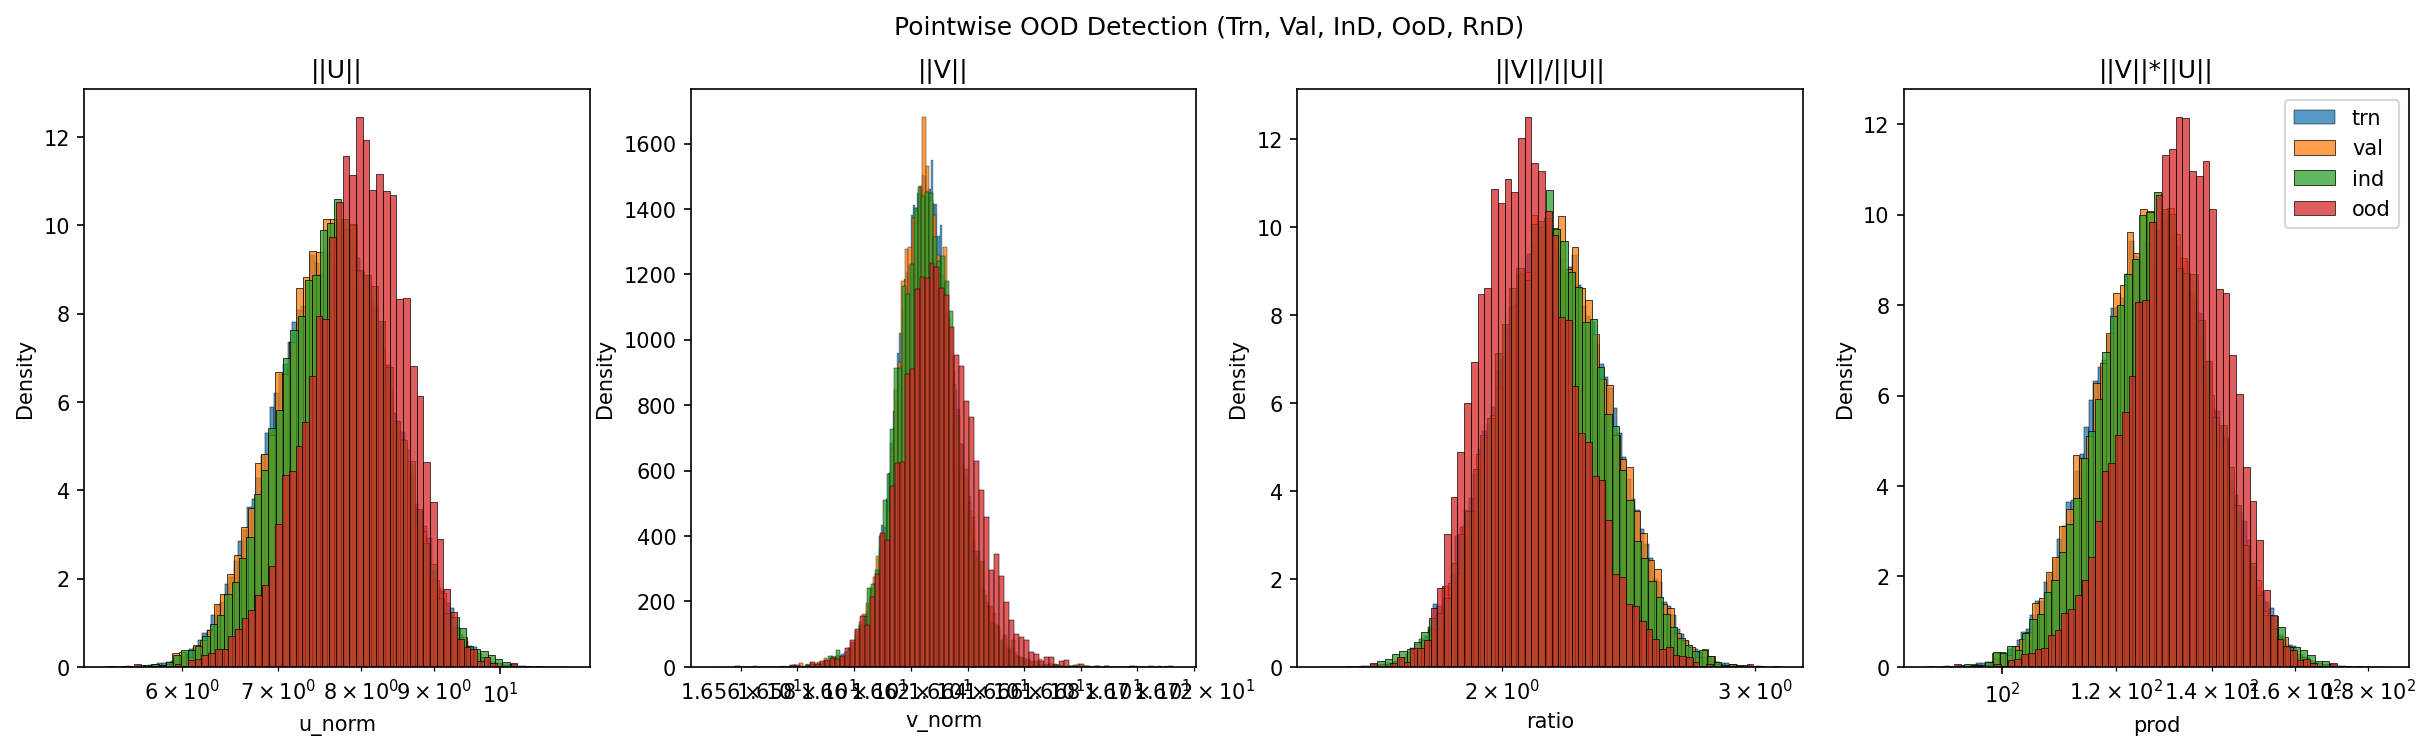

In [12]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

plt.rcParams['figure.figsize'] = (5, 5)
plt.rcParams['figure.dpi'] = 150

data_trn = pd.DataFrame(dict(u_norm=trn_u_norms, v_norm=trn_v_norms, ratio=trn_v_norms/trn_u_norms, prod=trn_v_norms*trn_u_norms, target=trn_targets))
data_val = pd.DataFrame(dict(u_norm=val_u_norms, v_norm=val_v_norms, ratio=val_v_norms/val_u_norms, prod=val_v_norms*val_u_norms, target=val_targets))
data_ind = pd.DataFrame(dict(u_norm=ind_u_norms, v_norm=ind_v_norms, ratio=ind_v_norms/ind_u_norms, prod=ind_v_norms*ind_u_norms, target=ind_targets))
if ood_str:
    data_ood = pd.DataFrame(dict(u_norm=ood_u_norms, v_norm=ood_v_norms, ratio=ood_v_norms/ood_u_norms, prod=ood_v_norms*ood_u_norms, target=ood_targets))
data_rnd = pd.DataFrame(dict(u_norm=rnd_u_norms, v_norm=rnd_v_norms, ratio=rnd_v_norms/rnd_u_norms, prod=rnd_v_norms*rnd_u_norms))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (20, 5))
fig.suptitle("Pointwise OOD Detection (Trn, Val, InD, OoD, RnD)")

sns.histplot(data=data_trn, x="u_norm", log_scale=True, fill=True, label='trn', stat='density', ax=ax1)
sns.histplot(data=data_val, x="u_norm", log_scale=True, fill=True, label='val', stat='density', ax=ax1)
sns.histplot(data=data_ind, x="u_norm", log_scale=True, fill=True, label='ind', stat='density', ax=ax1)
if ood_str:
    sns.histplot(data=data_ood, x="u_norm", log_scale=True, fill=True, label='ood', stat='density', ax=ax1)
# sns.histplot(data=data_rnd, x="u_norm", log_scale=True, fill=True, label='rnd', stat='density', ax=ax1)

sns.histplot(data=data_trn, x="v_norm", log_scale=True, fill=True, label='trn', stat='density', ax=ax2)
sns.histplot(data=data_val, x="v_norm", log_scale=True, fill=True, label='val', stat='density', ax=ax2)
sns.histplot(data=data_ind, x="v_norm", log_scale=True, fill=True, label='ind', stat='density', ax=ax2)
if ood_str:
    sns.histplot(data=data_ood, x="v_norm", log_scale=True, fill=True, label='ood', stat='density', ax=ax2)
# sns.histplot(data=data_rnd, x="v_norm", log_scale=True, fill=True, label='rnd', stat='density', ax=ax2)

sns.histplot(data=data_trn, x="ratio", log_scale=True, fill=True, label='trn', stat='density', ax=ax3)
sns.histplot(data=data_val, x="ratio", log_scale=True, fill=True, label='val', stat='density', ax=ax3)
sns.histplot(data=data_ind, x="ratio", log_scale=True, fill=True, label='ind', stat='density', ax=ax3)
if ood_str:
    sns.histplot(data=data_ood, x="ratio", log_scale=True, fill=True, label='ood', stat='density', ax=ax3)
# sns.histplot(data=data_rnd, x="ratio", log_scale=True, fill=True, label='rnd', stat='density', ax=ax3)

sns.histplot(data=data_trn, x="prod", log_scale=True, fill=True, label='trn', stat='density', ax=ax4)
sns.histplot(data=data_val, x="prod", log_scale=True, fill=True, label='val', stat='density', ax=ax4)
sns.histplot(data=data_ind, x="prod", log_scale=True, fill=True, label='ind', stat='density', ax=ax4)
if ood_str:
    sns.histplot(data=data_ood, x="prod", log_scale=True, fill=True, label='ood', stat='density', ax=ax4)
# sns.histplot(data=data_rnd, x="prod", log_scale=True, fill=True, label='rnd', stat='density', ax=ax4)

ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
ax3.title.set_text('||V||/||U||')
ax4.title.set_text('||V||*||U||')

plt.legend()
plt.show()

In [13]:
from scipy import stats
print("Trn", trn_v_norms.min(), trn_v_norms.max(), trn_v_norms.ptp())
print("Val", val_v_norms.min(), val_v_norms.max(), val_v_norms.ptp())
print("Ind", ind_v_norms.min(), ind_v_norms.max(), ind_v_norms.ptp())
if ood_str:
    print("Ood", ood_v_norms.min(), ood_v_norms.max(), ood_v_norms.ptp())
print("Rnd", rnd_v_norms.min(), rnd_v_norms.max(), rnd_v_norms.ptp())

if ood_str:
    ks_ind_ood = stats.kstest(ind_v_norms, ood_v_norms)
    print(ks_ind_ood)

Trn 16.550613 16.710709 0.16009521
Val 16.564499 16.708498 0.1439991
Ind 16.577162 16.686852 0.10968971
Ood 16.55816 16.712803 0.1546421
Rnd 28.743074 33.98748 5.2444057
KstestResult(statistic=0.1353801914038023, pvalue=3.35765348535135e-63, statistic_location=16.632595, statistic_sign=1)


[6, 1, 0, 3, 8, 4, 5, 2, 7, 9]


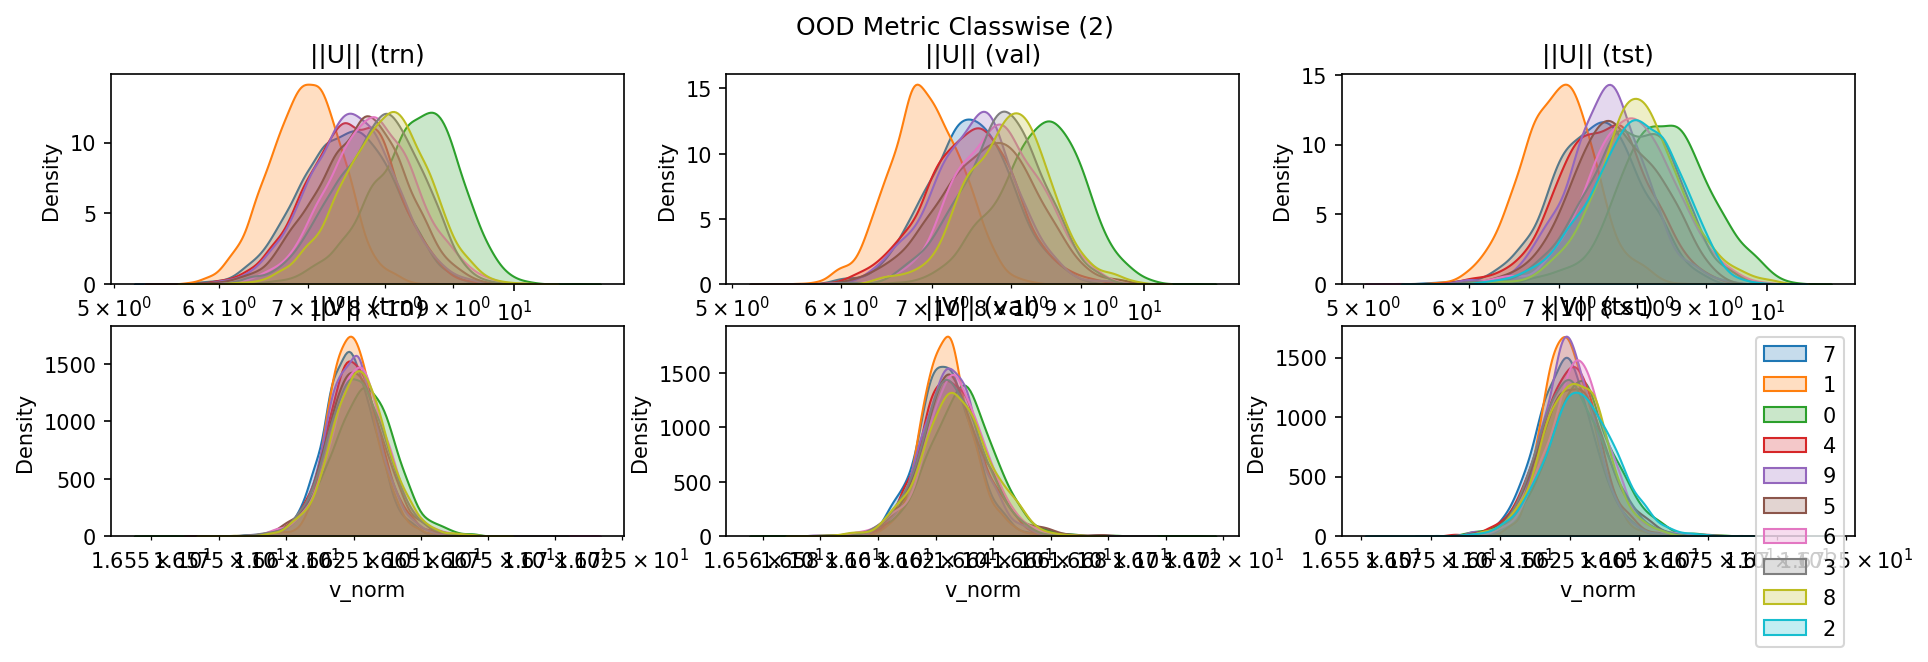

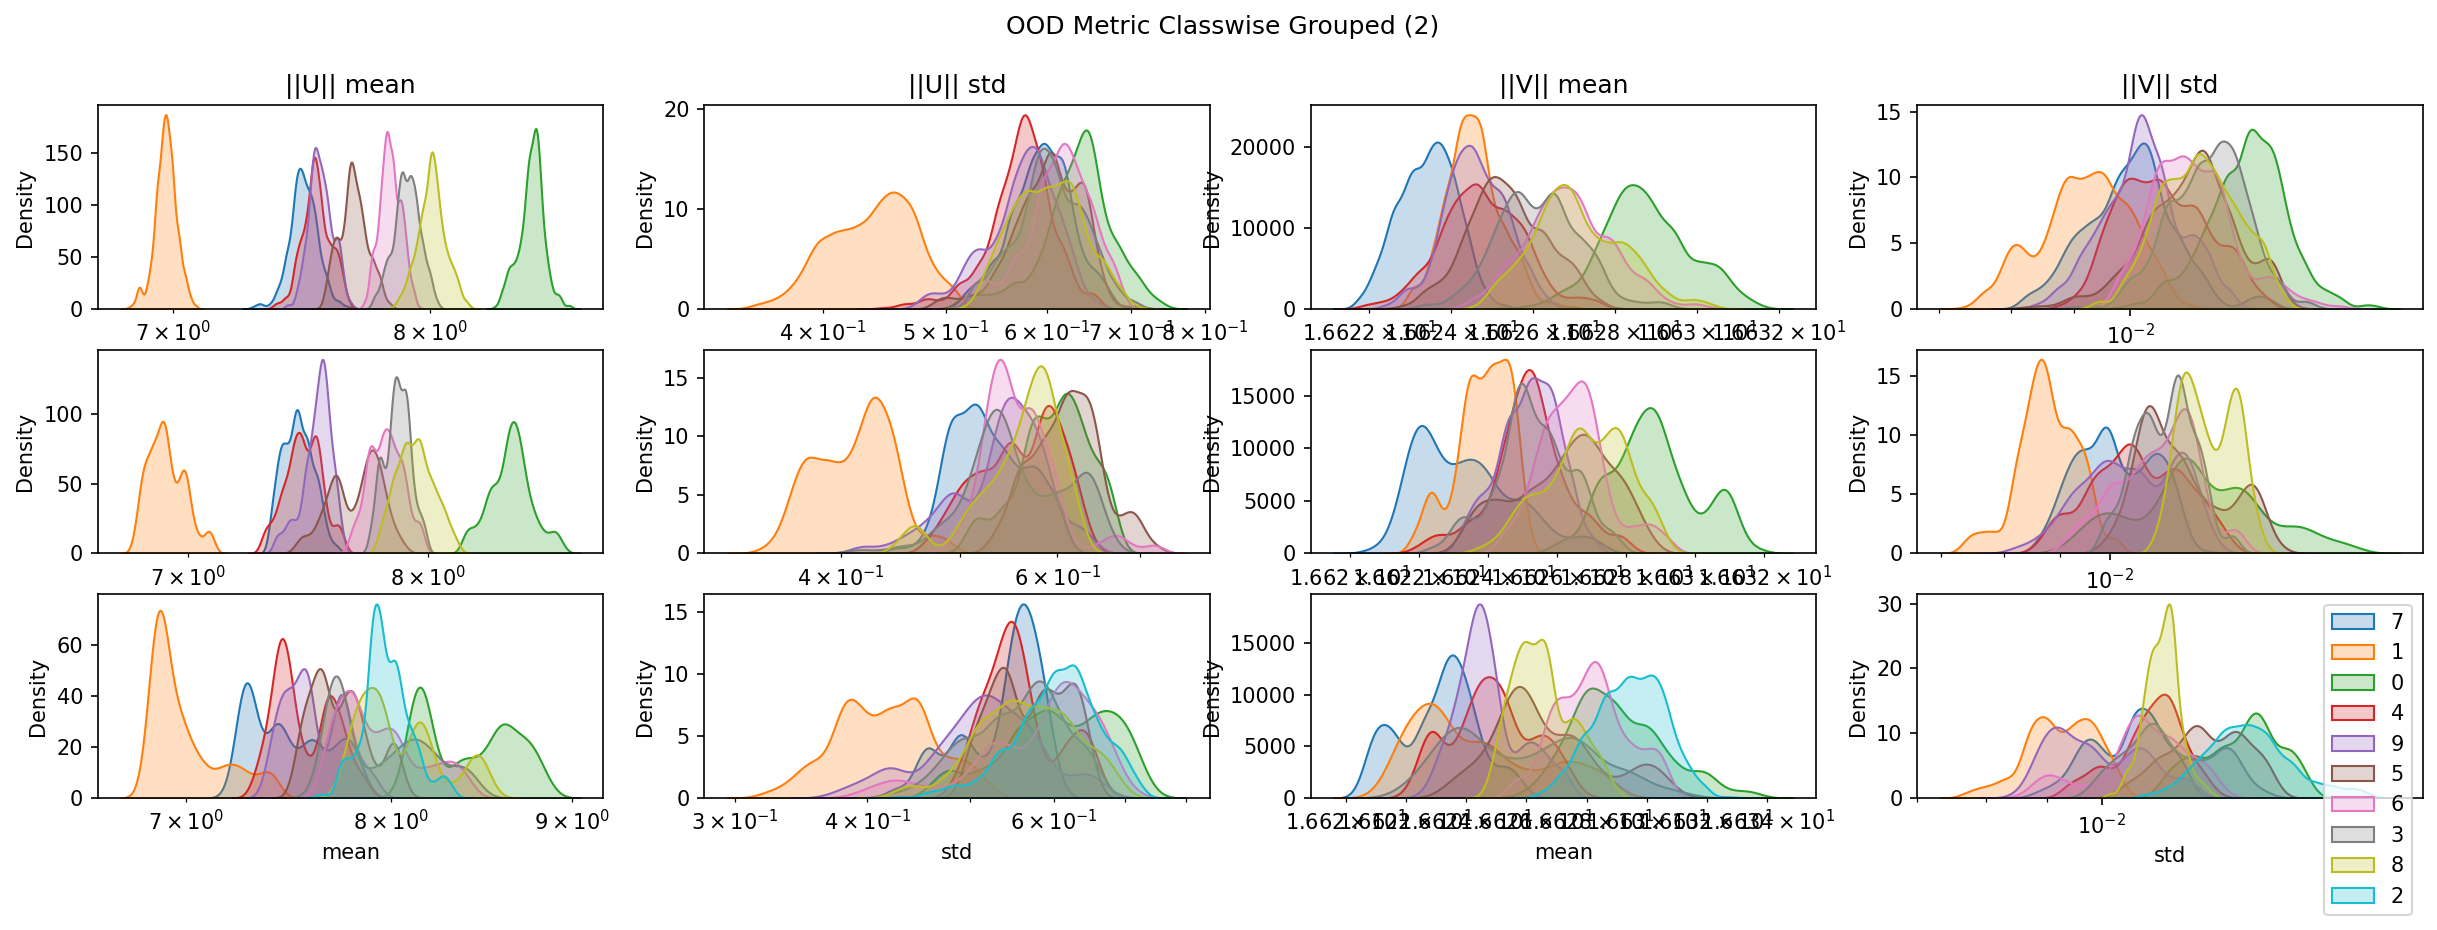

In [14]:
if ood_str:
    data_tst = pd.concat([data_ind, data_ood], axis=0)
else:
    data_tst = data_ind
all_targets = list(data_tst['target'].unique())
print(all_targets)

N = 128

pointwise_trn = {}
pointwise_val = {}
pointwise_tst = {}

groupwise_trn = {}
groupwise_val = {}
groupwise_tst = {}

for i in all_targets:
    df_trn = data_trn[data_trn['target'] == i]
    df_val = data_val[data_val['target'] == i]
    df_tst = data_tst[data_tst['target'] == i]
    pointwise_trn[i] = df_trn.copy()
    pointwise_val[i] = df_val.copy()
    pointwise_tst[i] = df_tst.copy()
    groupwise_trn[i] = df_trn.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_val[i] = df_val.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_tst[i] = df_tst.rolling(N).agg(['mean', 'std']).dropna().copy()

# pointwise
fig, ([ax1, ax2, ax3], [ax4, ax5, ax6]) = plt.subplots(2, 3, figsize = (15, 4))
fig.suptitle(f"OOD Metric Classwise ({ood_str})")

for i in all_targets:
    df_trn = pointwise_trn[i]
    df_val = pointwise_val[i]
    df_tst = pointwise_tst[i]
    if len(df_trn) > 0:
        sns.kdeplot(data=df_trn, x="u_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax1)
        sns.kdeplot(data=df_trn, x="v_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax4)
    if len(df_val) > 0:
        sns.kdeplot(data=df_val, x="u_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax2)
        sns.kdeplot(data=df_val, x="v_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax5)
    if len(df_tst) > 0:
        sns.kdeplot(data=df_tst, x="u_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax3)
        sns.kdeplot(data=df_tst, x="v_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax6)

ax1.title.set_text('||U|| (trn)')
ax2.title.set_text('||U|| (val)')
ax3.title.set_text('||U|| (tst)')
ax4.title.set_text('||V|| (trn)')
ax5.title.set_text('||V|| (val)')
ax6.title.set_text('||V|| (tst)')
plt.legend()
plt.show()
    
# groupwise
fig, ([ax1, ax2, ax3, ax4], [ax5, ax6, ax7, ax8], [ax9, axA, axB, axC]) = plt.subplots(3, 4, figsize = (20, 6))
fig.suptitle(f"OOD Metric Classwise Grouped ({ood_str})")

for i in all_targets:
    df_trn = groupwise_trn[i]
    df_val = groupwise_val[i]
    df_tst = groupwise_tst[i]
    if len(df_trn) > 0:
        sns.kdeplot(data=df_trn.u_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax1)
        sns.kdeplot(data=df_trn.u_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=ax2)
        sns.kdeplot(data=df_trn.v_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax3)
        sns.kdeplot(data=df_trn.v_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=ax4)
    if len(df_val) > 0:
        sns.kdeplot(data=df_val.u_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax5)
        sns.kdeplot(data=df_val.u_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=ax6)
        sns.kdeplot(data=df_val.v_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax7)
        sns.kdeplot(data=df_val.v_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=ax8)
    if len(df_tst) > 0:
        sns.kdeplot(data=df_tst.u_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax9)
        sns.kdeplot(data=df_tst.u_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=axA)
        sns.kdeplot(data=df_tst.v_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=axB)
        sns.kdeplot(data=df_tst.v_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=axC)

ax1.title.set_text('||U|| mean')
ax2.title.set_text('||U|| std')
ax3.title.set_text('||V|| mean')
ax4.title.set_text('||V|| std')
plt.legend()
plt.show()

In [15]:
# save vector norms for hypothesis testing

base_path = Path(f"assets/embeddings/{config.dataset_name}_{config.model_name}_M{config.emb_dims}_{ood_str}")
base_path.mkdir(exist_ok=True)

for i in range(5):
    df_trn = pointwise_trn.get(i, None)
    df_val = pointwise_val.get(i, None)
    df_tst = pointwise_tst.get(i, None)
    if df_trn is not None and len(df_trn) > 0:
        np.save(base_path / f"train_{i}.npy", df_trn.v_norm.values)
    if df_val is not None and len(df_val) > 0:
        np.save(base_path / f"val_{i}.npy", df_val.v_norm.values)
    if df_tst is not None and len(df_tst) > 0:
        np.save(base_path / f"test_{i}.npy", df_tst.v_norm.values)